# Caso COMPAS

**Jaime Fuentes Arias**

En este ejercicio se va a tratar de hacer un análisis exploratorio de datos (EDA) del dataset de COMPAS. Estos datos se refieren a convictos a los que se realiza un estudio para comprobar su nivel de reincidencia, para asegurar la decisión de concederles la libertad condicional. Sin embargo, se encontró en el modelo un sesgo que acrecentaba las disparidades raciales:
 
 * Era habitual que el modelo predijera falsamente a convictos de raza negra de ser futuros criminales, con una tasa o "puntuación" de casi el doble que los convictos de raza blanca.
 * Los convictos de raza blanca eran categorizados de menor riesgo más a menudo que los de raza negra.
 
Vamos a averiguar cómo se comportan las variables independientes más signifiactivas, cómo influyen el la variable que define la reincidencia, *decile_score*, y extraer conclusiones de estos datos.

In [1]:
import pandas as pd
import numpy as np
from plotnine import *

In [2]:
compas = pd.read_csv("datos/compas-scores.csv", 
                     parse_dates=["compas_screening_date", "dob", "c_jail_in",
                                   "c_jail_out", "r_jail_in", "r_jail_out", "c_offense_date","c_arrest_date",
                                   "r_offense_date", "vr_offense_date", "v_screening_date", "screening_date"])
compas.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,vr_offense_date,vr_charge_desc,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,type_of_assessment,decile_score.1,score_text,screening_date
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,NaT,NaN,Risk of Violence,1,Low,2013-08-14,Risk of Recidivism,1,Low,2013-08-14
1,2,michael ryan,michael,ryan,2014-12-31,Male,1985-02-06,31,25 - 45,Caucasian,...,NaT,NaN,Risk of Violence,2,Low,2014-12-31,Risk of Recidivism,5,Medium,2014-12-31
2,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,2013-07-05,Felony Battery (Dom Strang),Risk of Violence,1,Low,2013-01-27,Risk of Recidivism,3,Low,2013-01-27
3,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,NaT,NaN,Risk of Violence,3,Low,2013-04-14,Risk of Recidivism,4,Low,2013-04-14
4,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,NaT,NaN,Risk of Violence,6,Medium,2013-01-13,Risk of Recidivism,8,High,2013-01-13


In [3]:
compas.shape

(11757, 47)

Ya vemos que tenemos un número moderado de filas, 11757 y un gran número de columnas o variables, 47. Vamos a ver el tipo de esas columnas y hacer unas primeras predicciones de su significado.

## Descripción de variables

In [4]:
compas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11757 entries, 0 to 11756
Data columns (total 47 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   id                       11757 non-null  int64         
 1   name                     11757 non-null  object        
 2   first                    11757 non-null  object        
 3   last                     11757 non-null  object        
 4   compas_screening_date    11757 non-null  datetime64[ns]
 5   sex                      11757 non-null  object        
 6   dob                      11757 non-null  datetime64[ns]
 7   age                      11757 non-null  int64         
 8   age_cat                  11757 non-null  object        
 9   race                     11757 non-null  object        
 10  juv_fel_count            11757 non-null  int64         
 11  decile_score             11757 non-null  int64         
 12  juv_misd_count           11757 n

Lo primero que llama la atención son variables repetidas en las que cambia la letra inicial (c, r, vr, v). Tras búsquedas en internet se puede concluir que:

 * **c**. Serían los crímenes normales, la primera vez.
 * **r**. Serían los crímenes reincidentes.
 * **v**. Crímenes violentos.
 * **vr**. Crímenes violentos y reincidentes.
 
También nos fijamos en **num_vr_cases** y **num_r_cases** tienen todos sus valores nulos, por lo que las vamos a eliminar.

In [5]:
compas = compas.drop(columns=["num_r_cases", "num_vr_cases"])

### Variables de identificación

Estas son **id**, **name**, **first**, **last**, **dob**. Podemos decir que si los nombres son únicos para la persona (los que coincidan comprobameros más tarde que pertenecen a personas distintas), esta "cuatriada" es el identificador único para cada convicto.

In [6]:
compas.duplicated(["name"]).sum()

173

Vemos que hay 173 nombres repetidos, vamos a ver cuáles son.

In [7]:
compas[compas.duplicated(["name"])]

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,vr_offense_date,vr_charge_desc,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,type_of_assessment,decile_score.1,score_text,screening_date
1037,1038,anthony smith,anthony,smith,2014-07-28,Male,1968-02-08,48,Greater than 45,Caucasian,...,NaT,NaN,Risk of Violence,1,Low,2014-07-28,Risk of Recidivism,1,Low,2014-07-28
2021,2022,james rogers,james,rogers,2014-07-03,Male,1956-01-29,60,Greater than 45,Hispanic,...,NaT,NaN,Risk of Violence,1,Low,2014-07-03,Risk of Recidivism,3,Low,2014-07-03
2022,2023,troy smith,troy,smith,2013-03-22,Male,1993-09-08,22,Less than 25,African-American,...,NaT,NaN,Risk of Violence,6,Medium,2013-03-22,Risk of Recidivism,7,Medium,2013-03-22
2320,2321,terrance williams,terrance,williams,2013-03-02,Male,1982-11-19,33,25 - 45,African-American,...,2014-05-30,Battery,Risk of Violence,7,Medium,2013-03-02,Risk of Recidivism,6,Medium,2013-03-02
2390,2391,ricardo williams,ricardo,williams,2014-12-07,Male,1975-05-14,40,25 - 45,African-American,...,NaT,NaN,Risk of Violence,1,Low,2014-12-07,Risk of Recidivism,2,Low,2014-12-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11678,11679,roderick goddard,roderick,goddard,2014-03-29,Male,1989-06-08,26,25 - 45,African-American,...,2014-12-05,Throw Deadly Missile Into Veh,Risk of Violence,2,Low,2014-03-29,Risk of Recidivism,3,Low,2014-03-29
11713,11714,john brown,john,brown,2013-09-23,Male,1950-12-01,65,Greater than 45,African-American,...,NaT,NaN,Risk of Violence,1,Low,2013-09-23,Risk of Recidivism,1,Low,2013-09-23
11735,11736,carlos cruz,carlos,cruz,2013-02-02,Male,1980-01-21,36,25 - 45,Hispanic,...,NaT,NaN,Risk of Violence,3,Low,2013-02-02,Risk of Recidivism,10,High,2013-02-02
11746,11747,martin davis,martin,davis,2013-04-30,Male,1991-10-23,24,Less than 25,African-American,...,NaT,NaN,Risk of Violence,5,Medium,2013-04-30,Risk of Recidivism,4,Low,2013-04-30


Para comprobar que no son las mismas personas vamos a usar la fecha de nacimiento.

In [8]:
compas[compas.duplicated(["name", "dob"])]

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,vr_offense_date,vr_charge_desc,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,type_of_assessment,decile_score.1,score_text,screening_date
3761,3762,gueslly deravine,gueslly,deravine,2013-02-21,Male,1989-11-30,26,25 - 45,African-American,...,NaT,NaN,Risk of Violence,6,Medium,2013-02-21,Risk of Recidivism,5,Medium,2013-02-21
9956,9957,scott botkin,scott,botkin,2013-06-18,Male,1969-10-05,46,Greater than 45,Caucasian,...,NaT,NaN,Risk of Violence,2,Low,2013-06-18,Risk of Recidivism,3,Low,2013-06-18
11585,11586,alejandro cabrera,alejandro,cabrera,2013-10-07,Male,1990-03-30,26,25 - 45,Hispanic,...,NaT,NaN,Risk of Violence,3,Low,2013-10-07,Risk of Recidivism,4,Low,2013-10-07


Hay tres entradas repetidas para lo que podemos suponer que son la misma persona. Vamos a ver sus fechas del assesment y nivel de reincidencia.

In [9]:
compas[compas.name.isin(["gueslly deravine", 
                         "scott botkin", 
                         "alejandro cabrera"])][["name", "c_jail_in", "c_jail_out", 
                                                 "compas_screening_date", "score_text"]]

,name,c_jail_in,c_jail_out,compas_screening_date,score_text
604,gueslly deravine,2013-02-21 01:31:52,2013-02-21 07:44:48,2013-03-27,Medium
3701,scott botkin,2013-02-08 05:09:11,2013-02-08 02:00:40,2013-02-08,High
3761,gueslly deravine,NaT,NaT,2013-02-21,Medium
6536,alejandro cabrera,2013-09-23 12:36:24,2013-09-26 08:28:31,2013-09-23,Low
9956,scott botkin,NaT,NaT,2013-06-18,Low
11585,alejandro cabrera,NaT,NaT,2013-10-07,Low


Se ve que son distintas para la misma persona tanto la fecha de screening como el nivel de reincidencia, y que las fechas de entrada y salida solo aparecen para uno de los casos. Podemos añadir al grupo indentificativo de una persona su fecha de screening, así, todos los registros son únicos. ID = **id**, **name**, **first**, **last**, **dob**, **compas_screening_date**.

### Datos de tiempo

Aquí trataremos las fechas que aparecen en el dataset. Ya hemos visto *c_jail_in*, *c_jail_out* y *compas_screening_date*. Estas son las fechas de entrada y salida en prisión y la fecha del assesment. Pero hay otras fechas con el nombre de screening, vamos a compararla con *compas_screening_date*.

In [10]:
compas[["compas_screening_date", "dob", "c_jail_in", "c_jail_out", "r_jail_in", "r_jail_out", "c_offense_date",
        "c_arrest_date", "r_offense_date", "vr_offense_date", "v_screening_date", "screening_date"]].describe()

,compas_screening_date,dob,c_jail_in,c_jail_out,r_jail_in,r_jail_out,c_offense_date,c_arrest_date,r_offense_date,vr_offense_date,v_screening_date,screening_date
count,11757,11757,10577,10577,2460,2460,9157,1858,3703,882,11757,11757
unique,704,7800,10577,10517,984,953,1036,802,1090,599,704,704
top,2013-03-20 00:00:00,1990-05-02 00:00:00,2013-05-15 09:10:58,2013-09-12 10:31:00,2014-05-27 00:00:00,2014-02-18 00:00:00,2013-03-20 00:00:00,2013-02-06 00:00:00,2014-12-08 00:00:00,2015-08-15 00:00:00,2013-03-20 00:00:00,2013-03-20 00:00:00
freq,39,6,1,4,9,10,29,9,12,6,39,39
first,2013-01-01 00:00:00,1919-10-14 00:00:00,2013-01-01 01:31:55,2013-01-02 01:12:01,2013-01-04 00:00:00,2013-01-05 00:00:00,1987-11-07 00:00:00,1997-06-18 00:00:00,2013-01-03 00:00:00,2013-01-28 00:00:00,2013-01-01 00:00:00,2013-01-01 00:00:00
last,2014-12-31 00:00:00,1998-03-29 00:00:00,2016-03-11 10:26:16,2020-01-01 00:00:00,2016-03-29 00:00:00,2020-01-01 00:00:00,2014-12-30 00:00:00,2014-12-31 00:00:00,2016-03-29 00:00:00,2016-03-13 00:00:00,2014-12-31 00:00:00,2014-12-31 00:00:00


Por los valores parece que *compas_screening_date*, *v_screening_date* y *screening_date* son iguales, por lo que podemos eliminar las dos últimas del dataset.

In [11]:
compas = compas.drop(columns=["v_screening_date", "screening_date"])

El resto de fechas parecen normales. Sin embargo, para quitarnos una más, vamos a crear *days_jailed* = *c_jail_out* - *c_jail_in*.

In [12]:
day_diff = compas.c_jail_out - compas.c_jail_in
day_diff = day_diff.values/np.timedelta64(86400, "s")
compas["days_jailed"] = day_diff

compas = compas.drop(columns=["c_jail_out", "c_jail_in"])

Y lo mismo con los reincidentes.

In [13]:
day_diff_r = compas.r_jail_out - compas.r_jail_in
day_diff_r = day_diff_r.values/np.timedelta64(86400, "s")
compas["days_jailed_r"] = day_diff_r

compas = compas.drop(columns=["r_jail_out", "r_jail_in"])

También podemos eliminar algunas filas. Según ProPublica, si la fecha de imputación no está dentro de 30 días de la fecha del arresto, no se trata de la ofensa correcta.

In [14]:
compas = compas[(compas.days_b_screening_arrest <= 30)&(compas.days_b_screening_arrest >= -30)]

Podemos seguir con las variables de días.

In [15]:
compas[["days_b_screening_arrest", "c_days_from_compas", "r_days_from_arrest"]].describe()

,days_b_screening_arrest,c_days_from_compas,r_days_from_arrest
count,9396.000000,9396.000000,2126.000000
mean,-1.802682,24.904534,20.415334
std,5.029939,263.281189,76.099057
min,-30.000000,0.000000,-1.000000
25%,-1.000000,1.000000,0.000000
50%,-1.000000,1.000000,0.000000
75%,-1.000000,1.000000,1.000000
max,30.000000,9485.000000,993.000000


Vemos que son variables distintas. La mayoría de días de *c_days_from_compas* son 1 (y son todos positivos). *r_days_from_arrest* tiene valores negativos que se suponen erróneos o nulos. Debido a falta de información no se puede dar una descripción más exacta del sigificado

### Variables demográficas

En esta sección se entra en la controversia de la publicación inicial de este modelo. En los datos demográficos podemos encontrar edad, sexo y raza, siendo esta última la variable que más debate ha generado. Vamos a describirlas:

In [16]:
compas[["sex","age_cat","race"]].describe(include="object")

,sex,age_cat,race
count,9396,9396,9396
unique,2,3,6
top,Male,25 - 45,African-American
freq,7463,5367,4675


También existe la variable numérica edad pero vamos a obviarla ya que da la misma información que la tramificada. Vemos que la mayoría de convictos evaluados por COMPAS son hombres de raza negra entre 25 y 45 años. Después de describir las variables de contexto criminal y las del scoring veremos cómo estas demografías influyen en el resultado final. Podemos ver los niveles de las tres y su frecuencia.

In [17]:
compas.groupby(["sex","age_cat","race"])["id"].count()

sex     age_cat          race            
Female  25 - 45          African-American     546
                         Asian                  3
                         Caucasian            453
                         Hispanic              80
                         Native American        4
                         Other                 62
        Greater than 45  African-American     104
                         Asian                  1
                         Caucasian            223
                         Hispanic              30
                         Native American        2
                         Other                 20
        Less than 25     African-American     237
                         Asian                  1
                         Caucasian            114
                         Hispanic              29
                         Native American        1
                         Other                 23
Male    25 - 45          African-American    2217
        

Confirmamos que los más frecuentes son hombres de raza negra de mediana edad, seguidos por hombres blancos de la misma edad. En cuanto a mujeres se da el mismo comportamiento. Debido al menor número de convictos de otras razas vamos a agruparlas en "Af_Am", "Cauc", "Other".

In [18]:
mapping = {
        'African-American':'Af_Am',
        'Caucasian':'Cauc',
        'Asian':'Other',
        'Hispanic':'Other',
        'Native American':'Other',
        'Other':'Other'
    }

compas["race"] = compas['race'].replace(mapping)

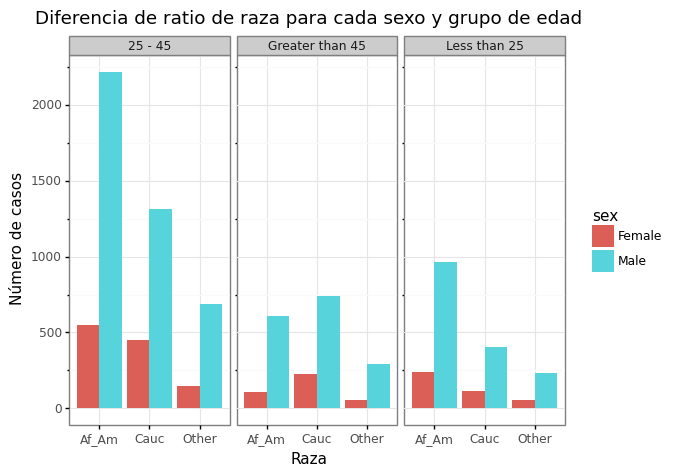

<ggplot: (-9223371918052731228)>

In [19]:
g_demo = compas[["sex","age_cat","race"]]
ggplot(g_demo, aes(x="race",fill="sex")) + geom_bar(position="dodge") +\
theme_bw() + facet_wrap("age_cat") +\
labs(title="Diferencia de ratio de raza para cada sexo y grupo de edad") +\
xlab("Raza") + ylab("Número de casos")

Se ve que el ratio de razas (Af_Am/Cauc) es menor para las mujeres en el tramo de edad clave (25-45). 

### Variables de contexto criminal

Aquí nos podemos encontrar la reincidencia, el número de imputaciones o arrestos anteriores, los cargos, el grado de imputación, etc. Empezamos por datos de imputaciones anteriores.

In [20]:
prior = ["juv_fel_count","juv_misd_count","juv_other_count","priors_count"]
compas[prior].describe()

,juv_fel_count,juv_misd_count,juv_other_count,priors_count
count,9396.000000,9396.00000,9396.000000,9396.000000
mean,0.058323,0.07865,0.099085,3.022137
std,0.451600,0.46379,0.468116,4.584740
min,0.000000,0.00000,0.000000,0.000000
25%,0.000000,0.00000,0.000000,0.000000
50%,0.000000,0.00000,0.000000,1.000000
75%,0.000000,0.00000,0.000000,4.000000
max,20.000000,13.00000,11.000000,38.000000


Vemos que la mayoría de convictos no cometieron delitos juveniles, con medias de menos de 0.1. Sin embargo, el número de delitos anteriores (no juveniles) sí es alto, entorno a 3 de media. Después se verá como afecta al scoring.

Pasamos a delitos originales, no reincidentes ni violentos.

In [21]:
crime = ["c_case_number", "c_charge_degree","c_charge_desc"]
compas[crime].describe(include="object")

,c_case_number,c_charge_degree,c_charge_desc
count,9396,9396,9391
unique,9396,3,464
top,14011210CF10A,F,Battery
freq,1,6093,1724


Vemos que *c_case_number* es solo un identificador así que lo obviamos. *c_charge_degree* y *c_charge_desc* corresponden al grado y la descripción del delito original. Vamos a ver los niveles que hay y su frecuencia.

In [22]:
compas.groupby(["c_charge_degree"])["id"].count()

c_charge_degree
F    6093
M    3296
O       7
Name: id, dtype: int64

La mayoría de delitos son de tipo F o "Felony" el tipo más grave, seguidos de M o "Misdmeanor" (grado medio, 1 año de cárcel) y O u "ordinary" (no requiere de cárcel por lo que se van a eliminar, según ProPublica).

In [23]:
compas = compas[compas.c_charge_degree != "O"]

compas.groupby(["c_charge_desc"])["id"].count().sort_values(ascending=False).head()

c_charge_desc
Battery                          1724
arrest case no charge            1243
Grand Theft in the 3rd Degree     623
Possession of Cocaine             622
Driving While License Revoked     238
Name: id, dtype: int64

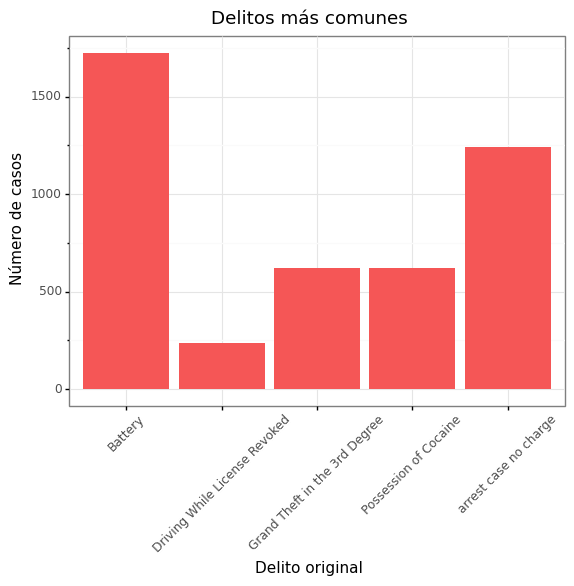

<ggplot: (-9223371918052527612)>

In [24]:
g_crime = pd.DataFrame(compas.groupby(["c_charge_desc"])["id"].count().sort_values(ascending=False).head()).reset_index()

ggplot(g_crime, aes(x="c_charge_desc",y="id")) + geom_bar(stat="identity",fill='#f55656') +\
theme_bw() + labs(title="Delitos más comunes") + xlab("Delito original") +\
ylab("Número de casos") + theme(axis_text_x = element_text(angle = 45))

Vemos que los más comunes son *Battery* o asalto con agravantes seguido de arrestos sin cargos. Despúes vendrían robo en tercer grado y posesión de cocaína.

Pasamos a delitos reincidentes.

In [25]:
compas.loc[:,"is_recid"] = compas.loc[:,"is_recid"].astype(str).astype(object)
reinc = ["is_recid","r_charge_degree","r_charge_desc","type_of_assessment"]
compas[reinc].describe(include="object")

,is_recid,r_charge_degree,r_charge_desc,type_of_assessment
count,9389,9389,3140,9389
unique,3,3,329,1
top,0,O,Possess Cannabis/20 Grams Or Less,Risk of Recidivism
freq,6201,6204,248,9389


Lo primero, vemos de el tipo de assessment sólo tiene un valor (que nos indica que la r es de reincidencia, confirmamos), por lo que la eliminamos.

In [26]:
compas = compas.drop(columns=["type_of_assessment"])

Vemos que ahora los tipos de crímenes más comunes son los "O", es decir, las infracciones ordinarias. Las infracciones originales no requieren de cárcel y las eliminamos, pero por falta de información de infracciones reincidentes se van a dejar. Podemos ver cómo cambian los delitos originales a los reincidentes.

In [27]:
compas.groupby('r_charge_degree')["id"].count()

r_charge_degree
F    1024
M    2161
O    6204
Name: id, dtype: int64

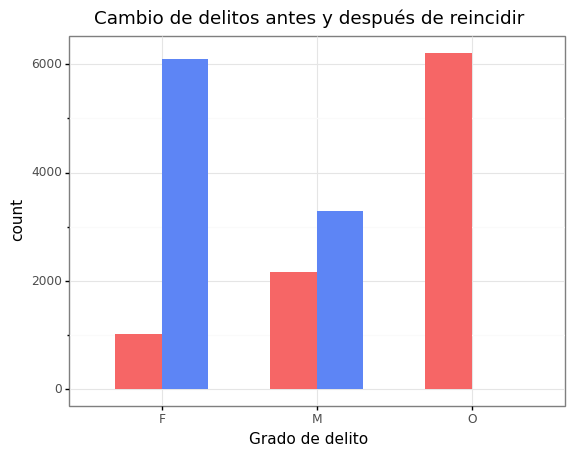

<ggplot: (-9223371918053038032)>

In [28]:
ggplot(compas) + geom_bar(aes(x="c_charge_degree"), fill='#5d85f5', position = position_nudge(x = 0.15), width=0.3) +\
geom_bar(aes(x="r_charge_degree"), fill='#f66666', position = position_nudge(x = -0.15), width=0.3) +\
labs(title="Cambio de delitos antes y después de reincidir") + xlab("Grado de delito") + theme_bw()

Vemos que los delitos originales (**azul**) son mayormente felonías (más graves). Los delitos reincidentes (**rojo**), al contrario, son en su mayoría infracciones leves.

Las descripciones más comunes son:

In [29]:
compas.groupby(["r_charge_desc"])["id"].count().sort_values(ascending=False).head()

r_charge_desc
Possess Cannabis/20 Grams Or Less    248
Driving License Suspended            246
Resist/Obstruct W/O Violence         174
Battery                              170
Operating W/O Valid License          163
Name: id, dtype: int64

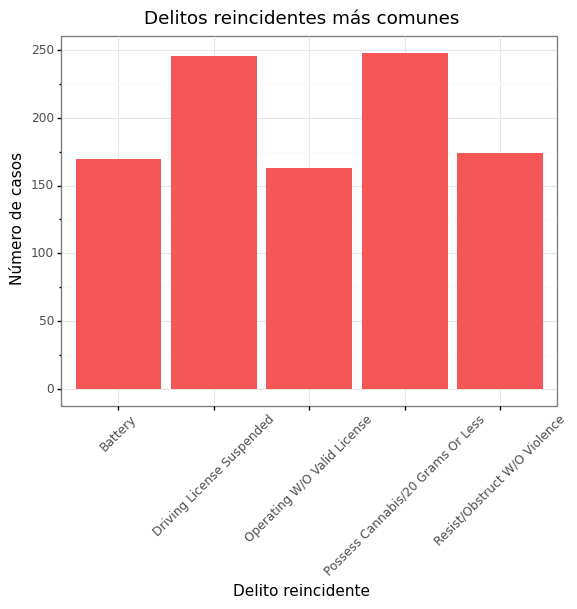

<ggplot: (-9223371918052730008)>

In [30]:
g_crime_r = pd.DataFrame(compas.groupby(["r_charge_desc"])["id"].count().sort_values(ascending=False).head()).reset_index()
ggplot(g_crime_r, aes(x="r_charge_desc",y="id")) + geom_bar(stat="identity",fill='#f55656') +\
theme_bw() + labs(title="Delitos reincidentes más comunes") + xlab("Delito reincidente") +\
ylab("Número de casos") + theme(axis_text_x = element_text(angle = 45))

Que como podemos suponer consisten en delitos menores. Ahora, la variable is recid tiene 3 niveles, que son:

In [31]:
compas["is_recid"].unique()

array(['0', '1', '-1'], dtype=object)

Vamos a suponer que los valores -1 son nulos y nos vamos a quedar con el resto, 0 no reincidente y 1 reincidente.

In [32]:
compas = compas[compas.is_recid != "-1"]

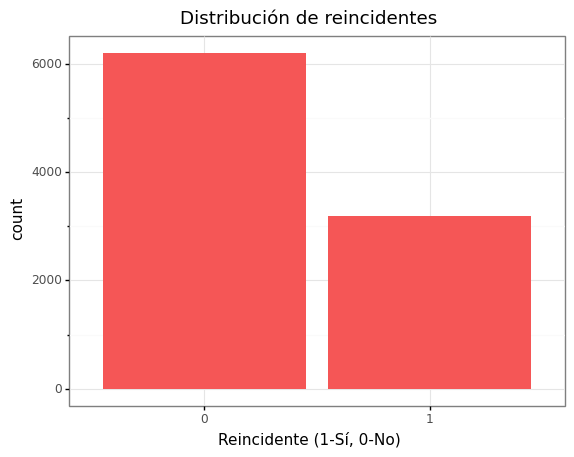

<ggplot: (-9223371918053120888)>

In [33]:
ggplot(compas) + geom_bar(aes(x="is_recid"), fill='#f55656') +\
labs(title="Distribución de reincidentes") + xlab("Reincidente (1-Sí, 0-No)") + theme_bw()

Podemos ver que la mayoría de convictos no son reincidentes. Pasamos a crímenes violentos y reincidentes violentos.

In [34]:
# no se por qué sale el warning si estoy usando el loc
compas.loc[:,"is_violent_recid"] = compas.loc[:,"is_violent_recid"].astype(str).astype(object)

D:\ArchivosDePrograma\Anaconda3\envs\ciencia_de_datos\lib\site-packages\pandas\core\indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [35]:
violent_r = ["is_violent_recid","vr_charge_degree","vr_charge_desc","v_type_of_assessment"]
compas[violent_r].describe(include="object")

,is_violent_recid,vr_charge_degree,vr_charge_desc,v_type_of_assessment
count,9388,744,744,9388
unique,2,9,86,1
top,0,(M1),Battery,Risk of Violence
freq,8644,316,304,9388


Lo primero vemos de nuevo que el tipo de assessment violento solo indica riesgo de violencia y lo eliminamos.

In [36]:
compas = compas.drop(columns=["v_type_of_assessment"])

Vamos a ver los niveles de las distintas variables.

In [37]:
print(compas.groupby(["is_violent_recid"])["id"].count().sort_values(ascending=False), "\n")
print(compas.groupby(["vr_charge_degree"])["id"].count().sort_values(ascending=False), "\n")
print(compas.groupby(["vr_charge_desc"])["id"].count().sort_values(ascending=False).head())

is_violent_recid
0    8644
1     744
Name: id, dtype: int64 

vr_charge_degree
(M1)     316
(F3)     204
(F2)     142
(F1)      38
(M2)      18
(F7)      18
(MO3)      4
(F6)       3
(F5)       1
Name: id, dtype: int64 

vr_charge_desc
Battery                           304
Felony Battery (Dom Strang)        40
Aggravated Assault W/Dead Weap     35
Battery on Law Enforc Officer      33
Aggrav Battery w/Deadly Weapon     33
Name: id, dtype: int64


Vemos que:

* La mayoría de convictos no son reincidentes violentos (is_violent_recid=0). Al igual que los convictos no violentos, la mayoría no son reincidentes.
* El mayor número de crímenes son delitos menores de primer grado (primer grado es más grave que tercero).
* La mayoría de crímenes vuelven a ser asaltos físicos.

### Variables de Score

Aquí se encuentran las variables que codifican el riesgo de reincidencia de un preso y mediante las que un juez u otra autoridad determinará si aceptar la libertad condicional o no.

In [38]:
compas[["decile_score","v_decile_score","decile_score.1"]] = compas[["decile_score","v_decile_score","decile_score.1"]].astype(str).astype(object)
score = ["decile_score","score_text","v_decile_score","v_score_text","decile_score.1"]
print(compas[score].describe(include="object"))

compas[["decile_score","v_decile_score","decile_score.1"]] = compas[["decile_score","v_decile_score","decile_score.1"]].astype(str).astype(int)

       decile_score score_text v_decile_score v_score_text decile_score.1
count          9388       9380           9388         9387           9388
unique           11          3             11            3             11
top               1        Low              1          Low              1
freq           2113       5367           2703         6405           2113


Primero vamos a tratar las variables "decile score". Vemos que tienen 11 niveles, lo cual indica que va a haber uno de ellos (probablemente -1) que sean valores nulos.

In [39]:
compas[["decile_score","v_decile_score","decile_score.1"]].apply(lambda x: sum(x<0))

decile_score      8
v_decile_score    1
decile_score.1    8
dtype: int64

In [40]:
compas = compas[(compas.decile_score != -1)&(compas.v_decile_score != -1)&(compas["decile_score.1"] != -1)]

Vemos que sí hay valores nulos en los deciles. Tambíen nos podemos dar cuenta que "decile_score" y "decile_score.1" son iguales:

In [41]:
print("Número de filas distintas entre columnas: ",sum(compas["decile_score"] != compas["decile_score.1"]))
compas = compas.drop(columns=["decile_score.1"])

Número de filas distintas entre columnas:  0


Ahora vamos con las de texto:

In [42]:
print(compas.groupby(["score_text"])["id"].count().sort_values(ascending=False), "\n")
print(compas.groupby(["v_score_text"])["id"].count().sort_values(ascending=False))

score_text
Low       5367
Medium    2336
High      1677
Name: id, dtype: int64 

v_score_text
Low       6400
Medium    2119
High       861
Name: id, dtype: int64


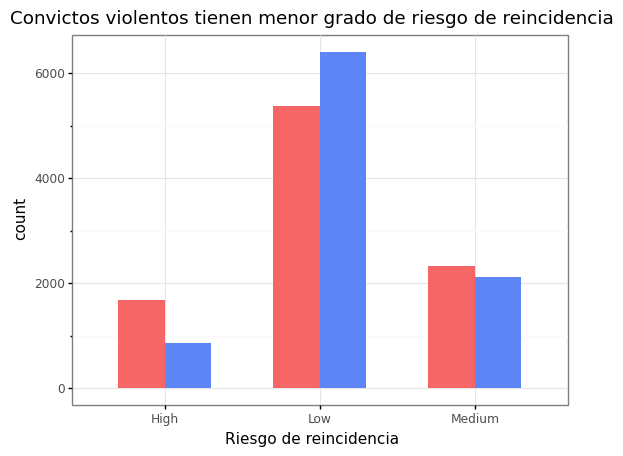

<ggplot: (-9223371918052312828)>

In [43]:
ggplot(compas) + geom_bar(aes(x="v_score_text"), fill='#5d85f5', position = position_nudge(x = 0.15), width=0.3) +\
geom_bar(aes(x="score_text"), fill='#f66666',position = position_nudge(x = -0.15), width=0.3) +\
labs(title="Convictos violentos tienen menor grado de riesgo de reincidencia") +\
xlab("Riesgo de reincidencia") + theme_bw()

Vemos que en la codificación de texto del score hay tres niveles: Bajo, Medio y Alto para el riesgo de reincidencia normal y violenta. La mayoría de ellos son de riesgo bajo, pero después lo mostraremos con otros factores. Vemos que los categorizados como violentos (**azul**) tienen valores mayores de riesgo bajo y menores de riesgo alto, al contrario que los convictos no violentos (**rojo**).

## ¿Cómo se influyen las variables entre sí?

Ya hemos descrito todas las variables que intervienen en el dataset. Ahora es turno de ver cómo estos datos determinan el nivel de scoring y por qué existe un debate abierto sobre la justicia del modelo, sobretodo en coste social.

En primer lugar vamos a ver cómo reaccionan algunas variables sobre otras. 

### Raza

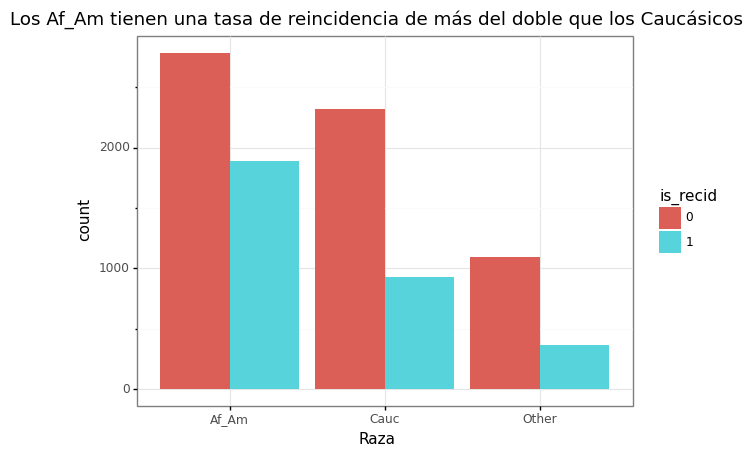

<ggplot: (-9223371918052499460)>

In [44]:
ggplot(compas) + geom_bar(aes(x="race", fill="is_recid"), position="dodge") +\
labs(title="Los Af_Am tienen una tasa de reincidencia de más del doble que los Caucásicos") +\
xlab("Raza") + theme_bw()

Como se dice en el título, se ve claramente que los convictos de raza negra tienen una tasa de reincidencia de más del doble que los caucásicos. Este dato podría ser uno de los que provoca ese sesgo tan controvertido del que se habla.

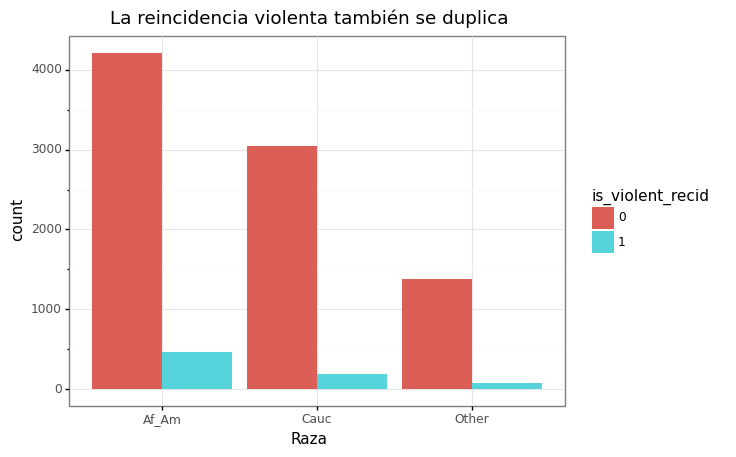

<ggplot: (-9223371918052340236)>

In [45]:
ggplot(compas) + geom_bar(aes(x="race", fill="is_violent_recid"), position="dodge") +\
labs(title="La reincidencia violenta también se duplica") +\
xlab("Raza") + theme_bw()

Se ve que la reincidencia violenta sigue siendo el doble para los afroamericanos. Más concretamente:

In [46]:
ratio_norm = len(compas[(compas.race=="Af_Am")&(compas.is_recid=="1")])/len(compas[(compas.race=="Cauc")&(compas.is_recid=="1")])
ratio_viol = len(compas[(compas.race=="Af_Am")&(compas.is_violent_recid=="1")])/len(compas[(compas.race=="Cauc")&(compas.is_violent_recid=="1")])

print("La reincidencia 'normal' para los afroamericanos es {} veces mayor".format(round(ratio_norm,2)))
print("La reincidencia 'violenta' para los afroamericanos es {} veces mayor".format(round(ratio_viol,2)))

La reincidencia 'normal' para los afroamericanos es 2.03 veces mayor
La reincidencia 'violenta' para los afroamericanos es 2.37 veces mayor


Vemos que la diferencia es clara. Vamos a ver cómo se reparte en los grados de los delitos, primero los normales:

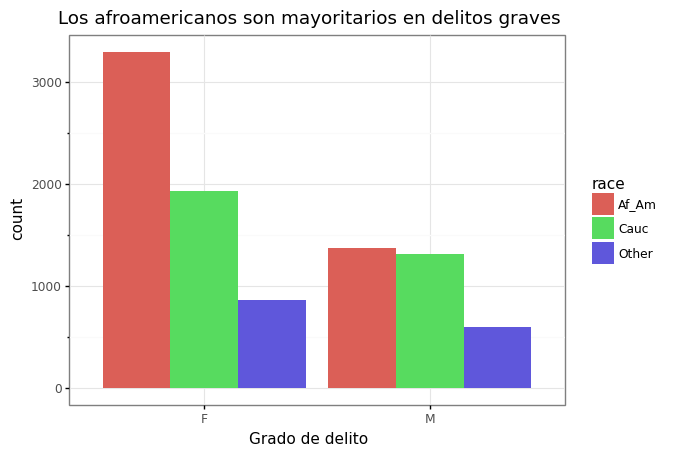

<ggplot: (-9223371918052508272)>

In [47]:
ggplot(compas) + geom_bar(aes(x="c_charge_degree", fill="race"), position="dodge") +\
labs(title="Los afroamericanos son mayoritarios en delitos graves") + xlab("Grado de delito") + theme_bw()

Se ve que el número de afroamericanos en delitos graves (felonías) es mucho mayor. Sigamos con delitos reincidentes:

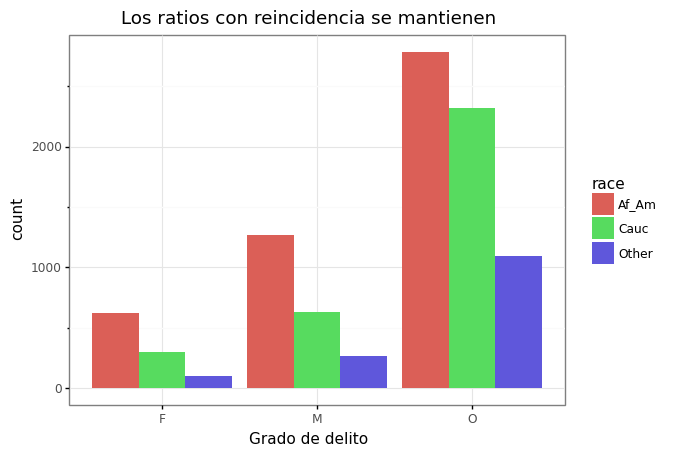

<ggplot: (-9223371918052138384)>

In [48]:
ggplot(compas) + geom_bar(aes(x="r_charge_degree", fill="race"), position="dodge") +\
labs(title="Los ratios con reincidencia se mantienen") + xlab("Grado de delito") + theme_bw()

Parece que el delitos reincidentes no destaca ningún ratio, son parecidos en los tres niveles. Por último veamos los delitos reincidentes violentos:

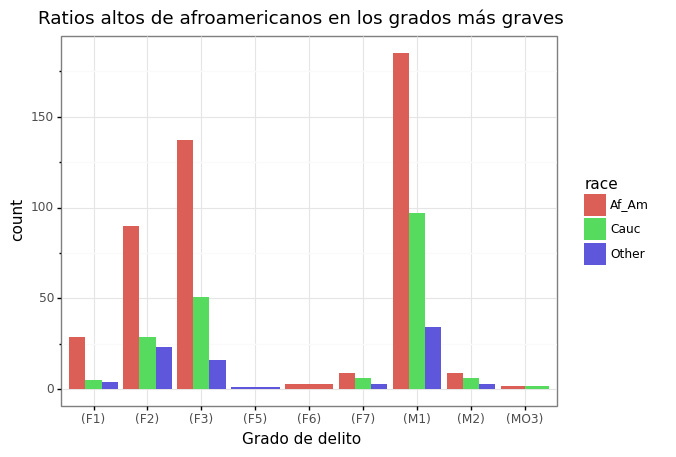

<ggplot: (-9223371918051715100)>

In [49]:
ggplot(compas[- compas.vr_charge_degree.isna()]) + geom_bar(aes(x="vr_charge_degree", fill="race"), position="dodge") +\
labs(title="Ratios altos de afroamericanos en los grados más graves") + xlab("Grado de delito") + theme_bw()

Se ve que la población negra es muy superior a la blanca en los grados F1-F3, los más graves, mientras que en F7-MO3 está mas igualado (en M1 no son el doble). Todas estas diferencias son las que aprenderá un modelo y el sesgo racista se manifestará en el scoring. Antes de continuar, nos fijamos en que la media del scoring violento es menor a la del scoring normal, ¿por qué ocurre esto?

In [50]:
media_n = compas["decile_score"].mean()
media_v = compas["v_decile_score"].mean()
print("La media del decile score violento es {} mientras que la del decile normal es {}".format(round(media_v,2),
                                                                                                round(media_n,2)))

La media del decile score violento es 3.54 mientras que la del decile normal es 4.31


¿Cómo es posible que la media de riesgo de convictos violentos sea menor que la normal? La lógica dictamina que en caso de violencia el modelo debería ser más estricto con el scoring, adaptándose y asignando una puntuación mayor. Hacemos una predicción y veamos cómo depende el scoring de la raza (una de las causas por las que realizamos este estudio).

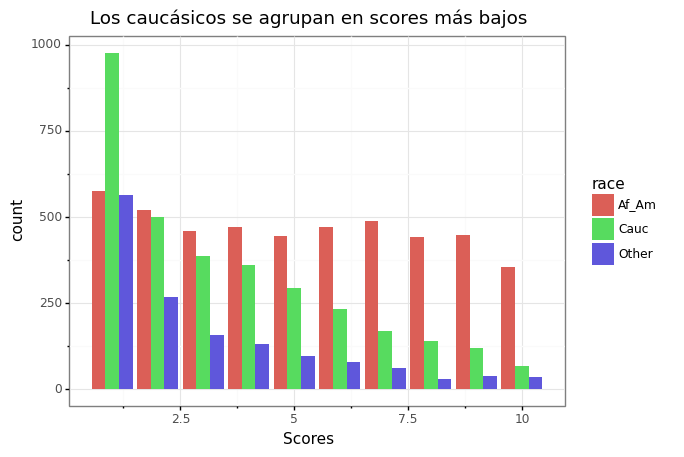

<ggplot: (-9223371918051705280)>

In [51]:
ggplot(compas) + geom_bar(aes(x="decile_score", fill="race"), position="dodge") +\
labs(title="Los caucásicos se agrupan en scores más bajos") + xlab("Scores") + theme_bw()

Vemos que los caucásicos se agrupan en torno a valores bajos de scoring, sobretodo el 1, y su frecuencia va disminuyendo a medida que el riesgo de reincidencia aumenta. Sin embargo, los convictos afroamericanos presentan una distribución más uniforme. Este comportamiento (más frecuencia en niveles altos) hace que la media total aumente. Vamos a ver el scoring violento.

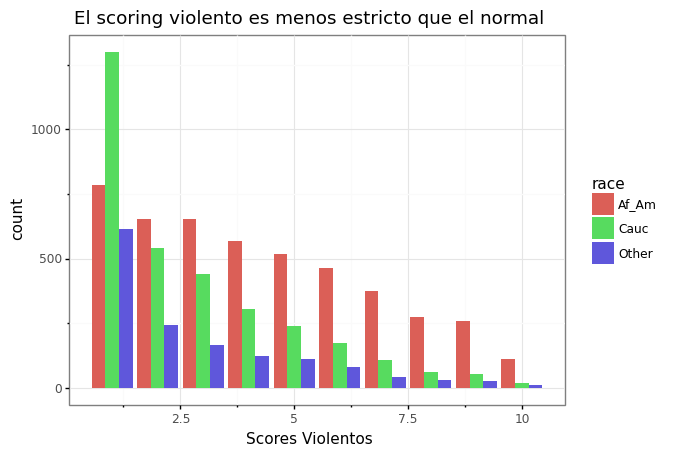

<ggplot: (-9223371918051300348)>

In [52]:
ggplot(compas) + geom_bar(aes(x="v_decile_score", fill="race"), position="dodge") +\
labs(title="El scoring violento es menos estricto que el normal") + xlab("Scores Violentos") + theme_bw()

Ya vemos directamente la causa de esa diferencia. En este caso los convictos de raza negra tienen una distribución más parecida a los blancos. Sin embargo, aún presentan mucha más frecuencia en scorings altos. A pesar de ser un scoring para convictos violentos, el número de casos (sobretodo en caucásicos) en nivel 1 de riesgo (el más bajo) es muy superior al del scoring normal. Esto lleva totalmente la contraria a la lógica ya expuesta de que el scoring violento debería ser más estricto y asignar valores de riesgo mayores a los convitctos.

In [53]:
degree_n = (len(compas[(compas.score_text=="High")&(compas.race=="Cauc")])
/(len(compas[(compas.score_text=="High")&(compas.race=="Af_Am")]) + len(compas[(compas.score_text=="High")&(compas.race=="Cauc")])))

degree_n *= 100
print("El ratio de caucásicos respecto del total para un riesgo alto es del {}%".format(round(degree_n,2)))

El ratio de caucásicos respecto del total para un riesgo alto es del 20.88%


Si el porcentaje de caucásicos con riesgo alto es 20.88%, significa que el de afroamericanos es 79.12%. Como sabemos, el score_text es la predicción del modelo para el riesgo de reincidencia, una probabilidad. Según esto, tenemos que los afroamericanos tienen 3.8 veces más probabilidad de reincidir que los caucásicos (según el modelo). Es una diferencia notable. Vamos a ver con el scoring violento:

In [54]:
degree_v = (len(compas[(compas.v_score_text=="High")&(compas.race=="Cauc")])
/(len(compas[(compas.v_score_text=="High")&(compas.race=="Af_Am")]) + len(compas[(compas.v_score_text=="High")&(compas.race=="Cauc")])))

degree_v *= 100
print("El ratio de caucásicos respecto del total para un riesgo alto es del {}%".format(round(degree_v,2)))

El ratio de caucásicos respecto del total para un riesgo alto es del 17.77%


Ahora tenemos que los caucásicos tienen un 17.77% de reincidir violentamente, lo que deja un 82.23% a los afroamericanos. Esto supone que este último colectivo tiene 4.6 veces más probabilidad de reincidir violentamente (según el modelo). La brecha entre razas ha crecido.

Para ver cómo de preciso ha sido el modelo vamos a construir una matriz de confusión. Vamos a realizarla primero para la reincidencia normal.

In [55]:
# Determinamos las predicciones y los valores reales
compas["pred_recid"] = compas["score_text"] != "Low"
compas["actual_recid"] = compas["is_recid"] == "1"

# Primero dividimos a los convictos de raza negra de los de raza blanca
w_subset = compas[compas.race=="Cauc"]
b_subset = compas[compas.race=="Af_Am"]

print("White")
print(pd.crosstab(w_subset.pred_recid, w_subset.actual_recid))
print("\nBlack")
print(pd.crosstab(b_subset.pred_recid, b_subset.actual_recid))

White
actual_recid  False  True 
pred_recid                
False          1749    475
True            569    454

Black
actual_recid  False  True 
pred_recid                
False          1465    560
True           1316   1330


Nos vamos a fijar en los falsos positivos, que se encuentran cuando el *pred_recid* muestra **True**, pero el *actual_recid* es **False**. Vemos que en raza blanca es de 569 casos y en raza negra de 1316. El número en sí ya muestra una disparidad pero vamos a calcular el ratio para poder comparar.

In [56]:
ratio_w = round((569/(569+1749))*100,2)
ratio_b = round((1316/(1316+1465))*100,2)

print("El ratio de falsos positivos para caucásicos es de {}%, mientras que para afroamericanos es de {}%".format(ratio_w, ratio_b))

El ratio de falsos positivos para caucásicos es de 24.55%, mientras que para afroamericanos es de 47.32%


Vemos que la probabilidad de que el modelo clasifique a un afroamericano erróneamente de alto riesgo es de casi el doble. De la misma manera lo podemos calcular para los falsos negativos.

In [57]:
ratio_w = round((475/(475+454))*100,2)
ratio_b = round((560/(560+1330))*100,2)

print("El ratio de falsos negativos para caucásicos es de {}%, mientras que para afroamericanos es de {}%".format(ratio_w, ratio_b))

El ratio de falsos negativos para caucásicos es de 51.13%, mientras que para afroamericanos es de 29.63%


En este caso pasa al contrario. El modelo califica erróneamente como bajo riesgo a casi el doble de caucásicos que de afroamericanos.

Vistos estos resultados vamos a ver qué ocurre con la reincidencia violenta.

In [58]:
# Determinamos las predicciones y los valores reales
compas["pred_recid_v"] = compas["v_score_text"] != "Low"
compas["actual_recid_v"] = compas["is_violent_recid"] == "1"

# Dividimos a los convictos de raza negra de los de raza blanca
w_subset = compas[compas.race=="Cauc"]
b_subset = compas[compas.race=="Af_Am"]

print("White")
print(pd.crosstab(w_subset.pred_recid_v, w_subset.actual_recid_v))
print("\nBlack")
print(pd.crosstab(b_subset.pred_recid_v, b_subset.actual_recid_v))

White
actual_recid_v  False  True 
pred_recid_v                
False            2459    127
True              592     69

Black
actual_recid_v  False  True 
pred_recid_v                
False            2484    178
True             1723    286


In [59]:
ratio_v_w = round((592/(592+2459))*100,2)
ratio_v_b = round((1723/(1723+2484))*100,2)

print("El ratio de falsos positivos para caucásicos es de {}%, mientras que para afroamericanos es de {}%".format(ratio_v_w, ratio_v_b))

El ratio de falsos positivos para caucásicos es de 19.4%, mientras que para afroamericanos es de 40.96%


Vemos que para el caso de reincidentes violentos las diferencias son parecidas. El modelo clasifica erróneamente como alto riesgo al doble de afroamericanos que de caucásicos.

In [60]:
ratio_v_w = round((127/(127+69))*100,2)
ratio_v_b = round((178/(178+286))*100,2)

print("El ratio de falsos negativos para caucásicos es de {}%, mientras que para afroamericanos es de {}%".format(ratio_v_w, ratio_v_b))

El ratio de falsos negativos para caucásicos es de 64.8%, mientras que para afroamericanos es de 38.36%


Determinamos que los resultados vuelven a ser parecidos a los reincidentes normales. El modelo clasifica erróneamente como bajo riesgo a algo menos del doble de caucásicos que de afroamericanos.

### Edad

Para estudiar la edad vamos a ver cómo influencia esta a las variables de score y a la de reincidencia.

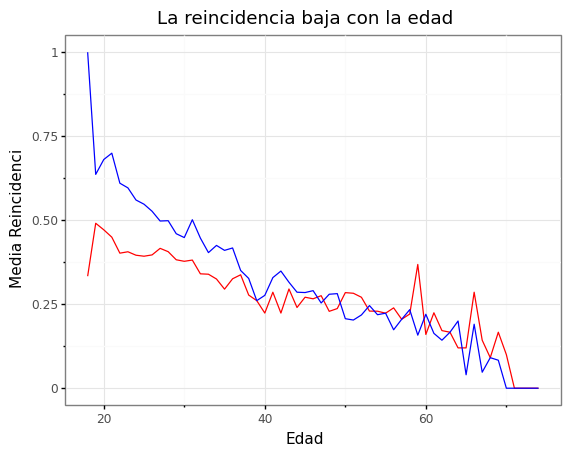

<ggplot: (-9223371918051251080)>

In [61]:
edad_recid = compas.groupby("age", as_index=False)[["actual_recid", "pred_recid"]].mean()
ggplot(edad_recid[edad_recid.age<75]) + geom_line(aes(x="age",y="actual_recid"), color="red") +\
geom_line(aes(x="age",y="pred_recid"), color="blue") +\
labs(title="La reincidencia baja con la edad") + xlab("Edad") + ylab("Media Reincidenci") +\
theme_bw() 

Al comparar ambas variables, la de reincidencia real (**roja**) y la predicha (**azul**), vemos varias tendencias por tramos (se ha cortado la edad a 75 años para evitar ruido producido por falta de datos). En primer lugar, vemos que para edades bajas, por debajo de los 35 años, las predicciones estiman valores muy superiores de reincidencia que los reales, lo que podría provocar que convictos jóvenes sean más frecuentemente denegados una posible libertad condicional. Al contrario, a partir de 35 parece que las predicciones se ajustan bien a los datos reales. En general se ve una tendencia clara, la probabilidad de reincidir disminuye con la edad. También podemos estudiar la reincidencia violenta.

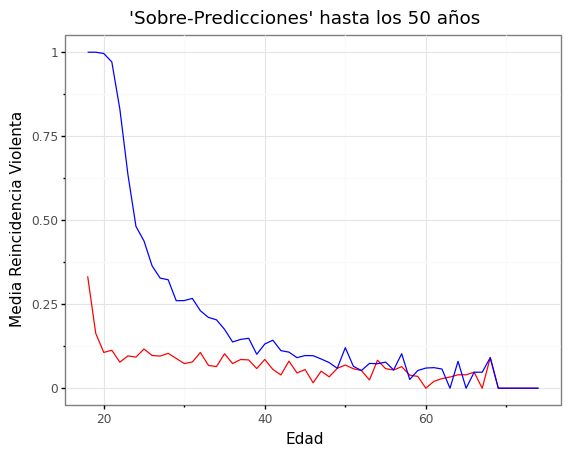

<ggplot: (-9223371918051220088)>

In [62]:
edad_recid_v = compas.groupby("age", as_index=False)[["actual_recid_v", "pred_recid_v"]].mean()
ggplot(edad_recid_v[edad_recid_v.age<75]) + geom_line(aes(x="age",y="actual_recid_v"), color="red") +\
geom_line(aes(x="age",y="pred_recid_v"), color="blue") +\
labs(title="'Sobre-Predicciones' hasta los 50 años") + xlab("Edad") + ylab("Media Reincidencia Violenta") +\
theme_bw()

En este caso vemos una tendencia más drástica. Hasta los 50 años la diferencia entre las predicciones de reincidencia violenta (**azul**) son mucho más altas que los valores reales (**rojo**). A pesar de la diferencia, este patrón seguiría el argumento de la lógica de ser más estrictos con reincidencias violentas, por lo que podría ser útil.

### Al final, ¿disminuye la reincidencia con el tiempo?

El objetivo de un modelo que prediga la reincidencia es que esta última decrezca con el tiempo hasta que se erradique, es decir, que los convictos que consigan su libertad no vuelvan a delinquir. Vamos a ver si la reincidencia baja con el tiempo.

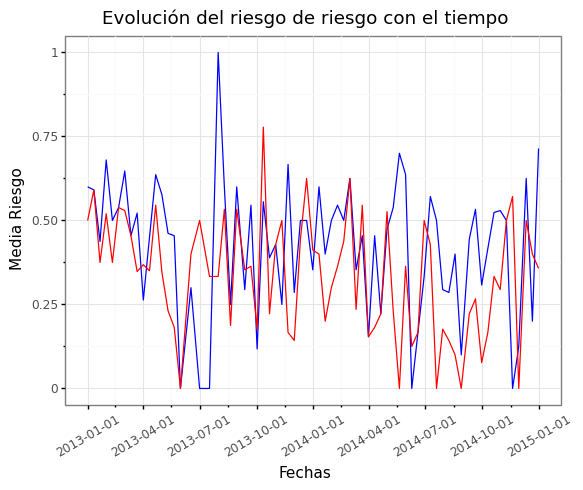

<ggplot: (-9223371918051213688)>

In [63]:
date_recid = compas.groupby("compas_screening_date", as_index=False)[["pred_recid", "actual_recid"]].mean()
ggplot(date_recid[::10]) + geom_line(aes(x="compas_screening_date",y="pred_recid"), color="blue") +\
geom_line(aes(x="compas_screening_date",y="actual_recid"), color="red") +\
labs(title="Evolución del riesgo de riesgo con el tiempo") + xlab("Fechas") + ylab("Media Riesgo") +\
theme_bw() + theme(axis_text_x = element_text(angle = 30))

Como fechas se han usado las mismas fechas de assesment COMPAS. Es notable comentar el ruido de esta gráfica, pero se pueden extraer conclusiones cualitativas. A pesar de que los valores de predicción (**azul**) parece que se mantienen constantes, los valores reales de reincidencia (**rojo**) tienen una ligera tendencia descendente a partir de finales de 2013. El incremento de ruido y las diferencias entre real y predicción en torno a julio de 2013 se deben a falta de datos.

## Conclusiones

Vamos a dar las conclusiones por las tres variables "independientes" que hemos estudiado.

**RAZA**:

* La reincidencia (normal y violenta) para convictos de raza negra es el doble de frecuente que para caucásicos. Además, en los delitos más graves (Felonías) suelen ser más frecuentes los afroamericanos.
* La media del scoring violento es menor que la del normal. Esto se debe a que los convictos afroamericanos tienen más probabilidad de recibir un scoring elevado en comparación con los caucásicos (y resto de etnias).
* Según el modelo, los convictos afroamericanos son 3.8 (para el normal) y 4.6 (para el violento) veces más probables de obtener un scoring de riesgo elevado de reincidencia.
* Para reincidencia normal y violenta, la probabilidad de que el modelo clasifique erróneamente (falsos positivos) a un afroamericano como alto riesgo es del doble que aun caucásico. Al mismo tiempo, la probabilidad de clasificar a un caucásico como bajo riesgo (falsos negativos) es de casi el doble que aun afroamericano.

**EDAD**

* En el caso de reincidencia normal, el modelo estima valores de reincidencia superiores a los reales para los convictos de menos de 35 años, mientras que de esa edad en adelante sí ajusta bien. Esto provoca que los convictos más jóvenes sean más probables de recibir un riesgo de reincidencia alto.
* En el caso de reincidencia violenta el gap es aún mayor. El modelo sobrestima el riesgo de los convictos hasta los 50 años. Sin embargo, al ser reincidencia violenta este aumento del riesgo puede llegar a ser útil a la hora de ser más estricto con los veredictos de libertad condicional.

**TIEMPO**

* Al estudiar la evolución de la reincidencia con el tiempo se observa un ligero decrecimiento de esta a partir de finales de 2013 y principios de 2014.

Como conclusión general aparte de las ya mencionadas, considero que un scoring que se basa en deciles no representa fielmente el riesgo de reincidencia de un convicto. Esta métrica representa un ranking de riesgo que puede verse afectado por diversos factores, desde el número de convictos hasta el grado que se le asigne a cada uno. Como ejemplo, imaginamos un preso que va a reincidir, pero se le estima un scoring más bajo que al 50% de los presos. Esto hará que este convicto pueda tener altas probabilidades de obtener la libertad. A mi juicio, un scoring numérico (no por deciles) sería una medida más fiable.